# Polish MiniLotto Extraction Analysis
This notebook contains code to fetch lotto extraction data, perform frequency analysis, and visualize the results with a color gradient.

## Importing Required Libraries

In [67]:
import requests
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

## Function to Fetch Lotto Data

In [68]:
def read_lotto_file(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        lines = response.text.split('\n')
        lotto_data = {}
        for line in lines:
            match = re.match(r'(\d+)\.\s+(\d{2}\.\d{2}\.\d{4})\s+([\d,]+)', line)
            if match:
                play_number = int(match.group(1))
                date = match.group(2)
                numbers = [int(num) for num in match.group(3).split(',')]
                lotto_data[play_number] = {
                    'gametype': 'MiniLotto',
                    'date': date,
                    'numbers': numbers
                }
        return lotto_data
    except requests.RequestException as e:
        print(f'Error fetching data: {e}')
url = 'http://www.mbnet.com.pl/el.txt'
lotto_results = read_lotto_file(url)

## Select plays time window

In [69]:
from datetime import datetime

def filter_lotto_results_by_date(lotto_results, start_date, end_date):
    """
    Filters the lotto results to include only those within the specified date range.

    :param lotto_results: Dictionary of lotto results.
    :param start_date: String of start date in 'dd.mm.yyyy' format.
    :param end_date: String of end date in 'dd.mm.yyyy' format.
    :return: Filtered dictionary of lotto results.
    """
    # Convert start_date and end_date to datetime objects
    start_date = datetime.strptime(start_date, "%d.%m.%Y")
    end_date = datetime.strptime(end_date, "%d.%m.%Y")

    # Filter the results
    filtered_results = {}
    for play_number, play_data in lotto_results.items():
        play_date = datetime.strptime(play_data['date'], "%d.%m.%Y")
        if start_date <= play_date <= end_date:
            filtered_results[play_number] = play_data

    return filtered_results

# Example usage
start_date = "13.12.2023"
end_date = "16.12.2023"
lotto_results = filter_lotto_results_by_date(lotto_results, start_date, end_date)

# Now, filtered_lotto_results contains only the plays between the start_date and end_date

## Last 10 draws

In [70]:
# Displaying the last 10 (newest) results from lotto_results dictionary
last_10_plays = sorted(lotto_results.keys())[-10:]
for play_number in last_10_plays:
    result = lotto_results[play_number]
    print(f"Play Number: {play_number}, Date: {result['date']}, Numbers: {result['numbers']}")


Play Number: 6308, Date: 13.12.2023, Numbers: [3, 5, 10, 25, 29]


## Frequency Analysis

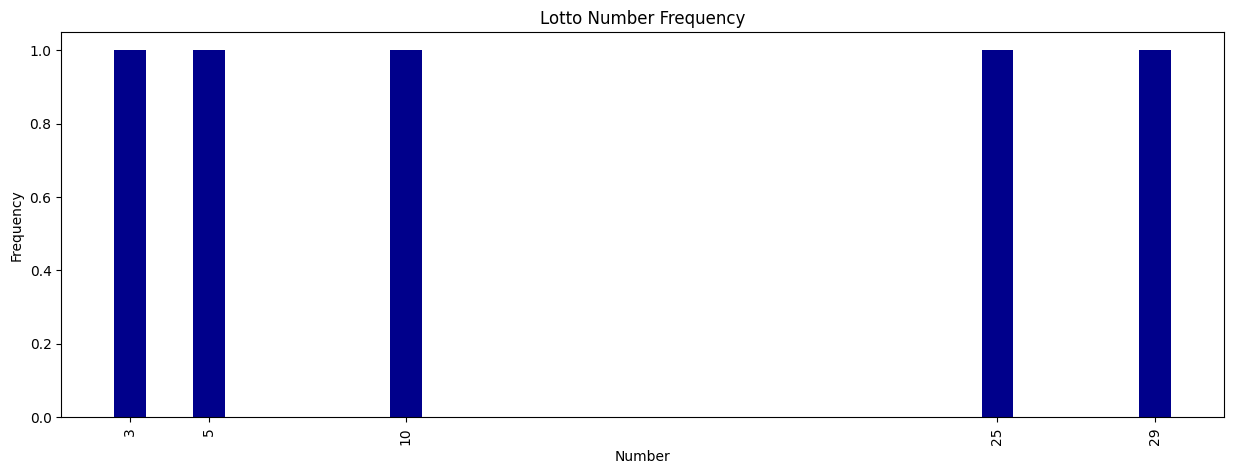

In [71]:
def frequency_analysis(lotto_data):
    numbers = []
    for play in lotto_data.values():
        numbers.extend(play['numbers'])
    return Counter(numbers)

number_frequency = frequency_analysis(lotto_results)
sorted_numbers = sorted(number_frequency.items(), key=lambda x: x[1])
numbers, frequencies = zip(*sorted_numbers)

# Define nine thresholds for the deciles
thresholds = np.quantile(frequencies, np.linspace(1/8, 7/8, 7))

# Define 10 colors for each decile
octile_colors = [
    'darkblue',    # Least frequent - coldest
    'blue',
    'lightblue',
    'green',
    'lightgreen',
    'yellow',
    'orange',
    'red'        # Most frequent - hottest
]

# Assign a color based on which decile each frequency falls into
colors = []
for freq in frequencies:
    for i, threshold in enumerate(thresholds):
        if freq <= threshold:
            colors.append(octile_colors[i])
            break
    else:
        colors.append(octile_colors[-1])  # Assign the last color to the top decile

# Plotting the results with the assigned colors
plt.figure(figsize=(15, 5))
plt.bar(numbers, frequencies, color=colors)
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Lotto Number Frequency')
plt.xticks(numbers, rotation=90)
plt.show()

## Print the five more and less probable numbers

In [72]:
# Sorting the numbers by frequency in descending order
most_frequent_numbers = sorted(number_frequency, key=number_frequency.get, reverse=True)[:5]

# Sorting the numbers by frequency in ascending order
least_frequent_numbers = sorted(number_frequency, key=number_frequency.get)[:5]

print("5 Most Probable Numbers:", most_frequent_numbers)
print("5 Least Probable Numbers:", least_frequent_numbers)

5 Most Probable Numbers: [3, 5, 10, 25, 29]
5 Least Probable Numbers: [3, 5, 10, 25, 29]


## Verifying if the Most or Least Probable Sets of Five Numbers Have Been Previously Drawn

In [73]:
def check_occurrence(lotto_data, numbers_set):
    occurrences = []
    for play_number, play_data in lotto_data.items():
        if set(play_data['numbers']) == numbers_set:
            occurrences.append((play_number, play_data['date']))
    return occurrences

# Most and least probable numbers
most_probable_numbers = set(most_frequent_numbers)
least_probable_numbers = set(least_frequent_numbers)

# Check if these sets ever occurred in the history
most_probable_occurrences = check_occurrence(lotto_results, most_probable_numbers)
least_probable_occurrences = check_occurrence(lotto_results, least_probable_numbers)

print("Occurrences of Most Probable Numbers:")
if most_probable_occurrences:
    for play_number, date in most_probable_occurrences:
        print(f"Play Number: {play_number}, Date: {date}")
else:
    print("None")

print("\nOccurrences of Least Probable Numbers:")
if least_probable_occurrences:
    for play_number, date in least_probable_occurrences:
        print(f"Play Number: {play_number}, Date: {date}")
else:
    print("None")


Occurrences of Most Probable Numbers:
Play Number: 6308, Date: 13.12.2023

Occurrences of Least Probable Numbers:
Play Number: 6308, Date: 13.12.2023
